In [62]:
import scipy as sp
import scipy.optimize as op
import numpy as np
import pylab as pl
import emcee
from lmfit.models import ExponentialGaussianModel
%matplotlib inline

In [63]:
filename = 'run562.txt'
infile = open(filename,'r')

xvals=[];ymeas=[]
while True:
    line = infile.readline()
    if not line: break
        
    items = line.split()
    xvals.append(float(items[0]))
    ymeas.append(float(items[1]))
    
xvals = np.array(xvals[2000:2300])
ymeas = np.array(ymeas[2000:2300])

infile.close()

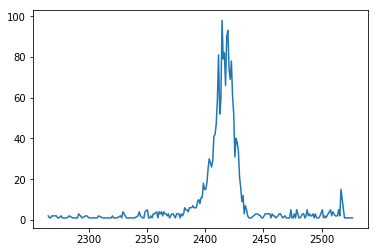

In [64]:
pl.subplot(111)
pl.plot(xvals,ymeas)
pl.show()

---

https://lmfit.github.io/lmfit-py/builtin_models.html#skewedgaussianmodel

In [65]:
def gauss_fn(p0, x):
    
    amp,mu,sigma,gamma = p0
    model = ExponentialGaussianModel()

    #amp*=sigma*np.sqrt(2*np.pi)
    
    # set initial parameter values
    params = model.make_params(amplitude=amp, center=mu, sigma=sigma, gamma=gamma)
    ymod = model.eval(params=params,x=x)
    
    return ymod

In [66]:
def lnlike(p0, x, y):
    
    # get model for these parameters:
    ymod = gauss_fn(p0,x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(ymeas!=0)]*np.log(ymeas[np.where(ymeas!=0)])) - np.sum(ymeas) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    
    return ll

In [118]:
# use maxvalue to guess amplitude:
a0 = np.max(ymeas)

# use position of maxvalue to guess mean:
m0 = xvals[np.argmax(ymeas)]

# just guess width:
s0 = 10.

# just guess skew:
g0 = 2.

# adjust the amplitude for the normalisation factor:
a0*=s0*np.sqrt(2*np.pi)

print(a0,m0,s0,g0)
p0 = np.array([a0,m0,s0,g0])

print(lnlike(p0, xvals, ymeas))

2456.4957091383803 2414.5 10.0 2.0
-560.0622088733062


In [119]:
bnds = ((None,None), (None,None), (0.1,None), (-10., 2.))

In [120]:
nll = lambda *args: -lnlike(*args)

result = op.minimize(nll, p0, bounds=bnds, args=(xvals, ymeas))
p1 = result["x"]

In [121]:
print(p1)

[1.67839539e+03 2.41504375e+03 9.16742478e+00 2.00000000e+00]


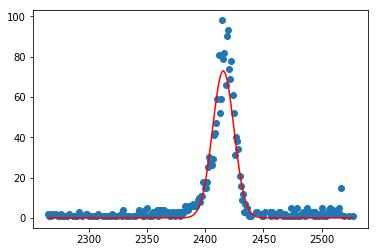

-395.6628778444765


In [122]:
yfit = gauss_fn(p1,xvals)
pl.subplot(111)
pl.scatter(xvals,ymeas)
pl.plot(xvals,yfit,c='r')
pl.show()

print(lnlike(p1, xvals, ymeas))

Text(0,0.5,'$\\sigma$')

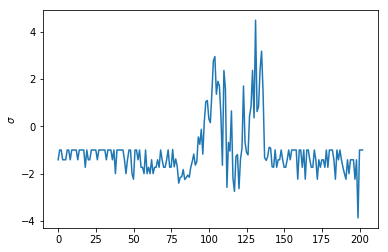

In [123]:
res = (yfit - ymeas)/np.sqrt(ymeas)
pl.plot(res)
pl.ylabel(r"$\sigma$")

These residuals look a bit weird to me. I'm wondering if the data are actually well represented by a skewed Gaussian.

---

In [124]:
ndim, nwalkers = 4, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [125]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(xvals, ymeas))

In [126]:
p0 = sampler.run_mcmc(pos, 500)

NaN value of lnprob for parameters: 
[1678.56955349 2414.296851      9.32178361    2.75991405]


/home/ben/anaconda3/lib/python3.6/site-packages/lmfit/lineshapes.py:201: RuntimeWarning: overflow encountered in exp
  return amplitude*(gamma/2) * exp(arg1) * erfc(arg2)
/home/ben/anaconda3/lib/python3.6/site-packages/lmfit/lineshapes.py:201: RuntimeWarning: overflow encountered in multiply
  return amplitude*(gamma/2) * exp(arg1) * erfc(arg2)
/home/ben/anaconda3/lib/python3.6/site-packages/lmfit/lineshapes.py:201: RuntimeWarning: invalid value encountered in multiply
  return amplitude*(gamma/2) * exp(arg1) * erfc(arg2)


ValueError: lnprob returned NaN.

In [ ]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

In [ ]:
import corner

fig = corner.corner(samples, labels=["$A$", "$\mu$", "$\sigma$","$\gamma$"],
                      truths=[a0, m0, s0, g0])
fig.savefig("triangle.png")